
### K-Means Cluster Analysis of Fidelity Fund Returns 

In this project, I conduct a k-means cluster analysis on a set of Fidelity mutual funds. This helps group similar funds based on their performance.

##### Preprocessing

In [1]:
import pandas as pd
import numpy as np

In [2]:
df0 = pd.read_csv('fido_returns.csv')

In [3]:
df0.head(3)

,Index,FSCEX,FSCBX,FSCIX,FDGIX,FADBX,FADAX,FDGTX,FSFCX,FAMUX,...,FVDKX,FDVLX,FVLKX,FSLSX,FASBX,FVSKX,FWWFX,FBVFX,FCFFX,FTFFX
0,2007-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
1,2007-01-04,0.000000,0.000000,0.000000,0.000826,0.000828,0.000840,0.001663,0.001165,0.001,...,0.0,0.000718,0.0,0.000377,0.000857,0.0,-0.004638,0.000726,0.000000,0.000000
2,2007-01-05,-0.010407,-0.010517,-0.010764,-0.004967,-0.004979,-0.005051,-0.005831,-0.001165,0.000,...,0.0,-0.008943,0.0,-0.011749,-0.012069,0.0,-0.009927,-0.008746,-0.006826,-0.006957


In [4]:
# store the tickers in a list called tickers
tickers = list(df0.columns[1:])
tickers[:5]

['FSCEX', 'FSCBX', 'FSCIX', 'FDGIX', 'FADBX']

In [5]:
# store the dates
dates = df0.Index.values
dates[:5]

array(['2007-01-03', '2007-01-04', '2007-01-05', '2007-01-08',
       '2007-01-09'], dtype=object)

In [6]:
# drop the index column
del df0['Index']

In [7]:
# store the dataframe values
vals = df0.values

In [8]:
# transpose the data, putting funds on rows and timepoints on columns
vals_t = vals.transpose()

In [9]:
vals_t

array([[ 0.        ,  0.        , -0.0104072 , ..., -0.00193986,
        -0.01368545,  0.01329703],
       [ 0.        ,  0.        , -0.01051664, ..., -0.00157109,
        -0.01385338,  0.01346022],
       [ 0.        ,  0.        , -0.01076437, ..., -0.00158806,
        -0.01376242,  0.0134445 ],
       ...,
       [ 0.        ,  0.00072595, -0.00874641, ...,  0.00109709,
        -0.01380094,  0.01105594],
       [ 0.        ,  0.        , -0.00682597, ...,  0.00284698,
        -0.01071822,  0.00715823],
       [ 0.        ,  0.        , -0.00695655, ...,  0.00280899,
        -0.01128362,  0.00777114]])

In [10]:
vals_t.shape

(927, 1731)

In [11]:
# build the dataframe with transposed data, calling it dft.
dft = pd.DataFrame(data=vals_t, index=df0.columns, columns=dates)

In [12]:
dft.head()

,2007-01-03,2007-01-04,2007-01-05,2007-01-08,2007-01-09,2007-01-10,2007-01-11,2007-01-12,2007-01-16,2007-01-17,...,2013-10-28,2013-10-29,2013-10-30,2013-10-31,2013-11-01,2013-11-04,2013-11-05,2013-11-06,2013-11-07,2013-11-08
FSCEX,0.0,0.000000,-0.010407,0.003686,-0.001841,-0.000614,0.008568,0.004863,0.000000,-0.003645,...,-0.000386,0.003470,-0.006178,-0.001163,-0.003885,0.010070,-0.005797,-0.001940,-0.013685,0.013297
FSCBX,0.0,0.000000,-0.010517,0.003724,-0.001240,-0.001241,0.008658,0.004914,-0.000613,-0.003070,...,-0.000391,0.003512,-0.006252,-0.001177,-0.003932,0.009802,-0.005870,-0.001571,-0.013853,0.013460
FSCIX,0.0,0.000000,-0.010764,0.003781,-0.001619,0.000000,0.008602,0.004274,0.000000,-0.003203,...,-0.000633,0.003789,-0.006323,-0.000952,-0.003817,0.009830,-0.005696,-0.001588,-0.013762,0.013445
FDGIX,0.0,0.000826,-0.004967,0.002487,-0.000828,0.000828,0.004955,0.005750,-0.000819,0.001638,...,0.000000,0.004001,-0.005147,-0.004598,0.001727,0.003444,-0.003444,0.002871,-0.014439,0.014439
FADBX,0.0,0.000828,-0.004979,0.002493,-0.000830,0.000830,0.004967,0.004942,0.000000,0.000821,...,0.000000,0.003704,-0.004941,-0.004344,0.001864,0.003099,-0.003099,0.002480,-0.014972,0.014972


##### Read Data into Spark DataFrame

In [13]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

filename = 'fido_returns_funds_on_rows.csv'
df = spark.read.csv(filename,  inferSchema=True, header = True)

Assemble the Features

In [14]:
feats = []
for i in df.schema.names:
    feats.append(i)   

assembler = VectorAssembler(inputCols=feats, outputCol="features")
dataset=assembler.transform(df)
# dataset.select("*").show(truncate=False)

In [15]:
dataset.select(dataset.features).show(5)

+--------------------+
|            features|
+--------------------+
|[0.0,0.0,-0.01040...|
|[0.0,0.0,-0.01051...|
|[0.0,0.0,-0.01076...|
|[0.0,8.26105E-4,-...|
|[0.0,8.2815740000...|
+--------------------+
only showing top 5 rows



In [16]:
pandasDF = dataset.toPandas()
print(pandasDF[2:5])

   2007-01-03  2007-01-04  2007-01-05  2007-01-08  2007-01-09  2007-01-10  \
2         0.0    0.000000   -0.010764    0.003781   -0.001619    0.000000   
3         0.0    0.000826   -0.004967    0.002487   -0.000828    0.000828   
4         0.0    0.000828   -0.004979    0.002493   -0.000830    0.000830   

   2007-01-11  2007-01-12  2007-01-16  2007-01-17  ...  2013-10-29  \
2    0.008602    0.004274    0.000000   -0.003203  ...    0.003789   
3    0.004955    0.005750   -0.000819    0.001638  ...    0.004001   
4    0.004967    0.004942    0.000000    0.000821  ...    0.003704   

   2013-10-30  2013-10-31  2013-11-01  2013-11-04  2013-11-05  2013-11-06  \
2   -0.006323   -0.000952   -0.003817    0.009830   -0.005696   -0.001588   
3   -0.005147   -0.004598    0.001727    0.003444   -0.003444    0.002871   
4   -0.004941   -0.004344    0.001864    0.003099   -0.003099    0.002480   

   2013-11-07  2013-11-08                                           features  
2   -0.013762    0.013

##### Set up.

In [17]:
kmeans = KMeans().setK(3).setSeed(314).setMaxIter(10)
model = kmeans.fit(dataset)

predictions = model.transform(dataset)

In [18]:
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.4948749854024883


In [24]:
'''
  Here I define a function that:
  - takes integers for lower and upper bounds, and a df
  - fits K-means with k within this range
  - compute the silhouette score for each k
  - returns a pandas df with cols containing k and scores
'''

def kmeans_range(lower_bound, upper_bound, spark_df):

    feats = []
    for i in spark_df.schema.names:
        feats.append(i)   
    assembler = VectorAssembler(inputCols=feats, outputCol="features")
    dataset=assembler.transform(spark_df)
    
    
    kvalues = []
    sil_scores = []
    for k in range(lower_bound, upper_bound):
        kvalues.append(k)
        kmeans = KMeans().setK(k).setSeed(314).setMaxIter(10)
        model = kmeans.fit(dataset)
        
        # Silhouette Score
        predictions = model.transform(dataset)
        evaluator = ClusteringEvaluator()
        silhouette = evaluator.evaluate(predictions)
        print("Silhouette with squared euclidean distance = " + str(silhouette))
        sil_scores.append(silhouette)
        
    # create df
    global kmeans_range_df
    
    data = {'k':kvalues,
           'silhouette score':sil_scores}
    kmeans_range_df = pd.DataFrame(data=data)
    return kmeans_range_df

        

In [25]:
kmeans_210 = kmeans_range(2,11,df)
kmeans_210

Silhouette with squared euclidean distance = 0.6023964908433326
Silhouette with squared euclidean distance = 0.4948749854024883
Silhouette with squared euclidean distance = 0.5007957244197214
Silhouette with squared euclidean distance = 0.45942626092737193
Silhouette with squared euclidean distance = 0.4197571586160717
Silhouette with squared euclidean distance = 0.46285078633569376
Silhouette with squared euclidean distance = 0.30461359447002734
Silhouette with squared euclidean distance = 0.37118713118241875
Silhouette with squared euclidean distance = 0.4032173113386648


,k,silhouette score
0,2,0.602396
1,3,0.494875
2,4,0.500796
3,5,0.459426
4,6,0.419757
5,7,0.462851
6,8,0.304614
7,9,0.371187
8,10,0.403217


In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

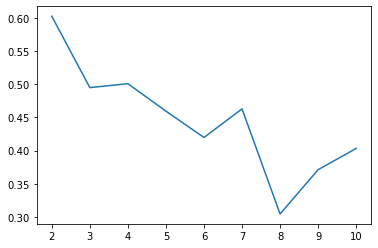

In [34]:
plt.plot(kmeans_range_df['k'], kmeans_range_df['silhouette score'])

In [36]:
#!export PATH=/Library/TeX/texbin:$PATH
!jupyter nbconvert --to pdf `pwd`/*.ipynb

[NbConvertApp] Converting notebook /sfs/qumulo/qhome/dbw2tn/ds5110/assignments/M5_8_clustering/fidelity_fund_clustering.ipynb to pdf
[NbConvertApp] Support files will be in fidelity_fund_clustering_files/
[NbConvertApp] Making directory ./fidelity_fund_clustering_files
[NbConvertApp] Writing 44421 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 71786 bytes to /sfs/qumulo/qhome/dbw2tn/ds5110/assignments/M5_8_clustering/fidelity_fund_clustering.pdf
